# Problem Statement

In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

# --> IEEE-CIS Fraud Detection
Can you detect fraud from customer transactions?

Dataset --> https://www.kaggle.com/competitions/ieee-fraud-detection

# About the dataset
The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

Categorical Features - Transaction
ProductCD

card1 - card6

addr1, addr2

P_emaildomain

R_emaildomain

M1 - M9

Categorical Features - Identity

DeviceType

DeviceInfo

id_12 - id_38

The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

## Credits to Tudor Lapusan  for the detailed Dtaset description:

https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203





Transaction table

“It contains money transfer and also other gifting goods and service, like you booked a ticket for others, etc.”

TransactionDT: timedelta from a given reference datetime (not an actual timestamp)

“TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183.”

TransactionAMT: transaction payment amount in USD

“Some of the transaction amounts have three decimal places to the right of the decimal point. There seems to be a link to three decimal places and a blank addr1 and addr2 field. Is it possible that these are foreign transactions and that, for example, the 75.887 in row 12 is the result of multiplying a foreign currency amount by an exchange rate?”

ProductCD: product code, the product for each transaction

“Product isn't necessary to be a real 'product' (like one item to be added to the shopping cart). It could be any kind of service.”

card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

addr: address

“both addresses are for purchaser
addr1 as billing region
addr2 as billing country”
dist: distance
"distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”

P_ and (R__) emaildomain: purchaser and recipient email domain
“ certain transactions don't need recipient, so R_emaildomain is null.”

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
“Can you please give more examples of counts in the variables C1-15? Would these be like counts of phone numbers, email addresses, names associated with the user? I can't think of 15.
Your guess is good, plus like device, ipaddr, billingaddr, etc. Also these are for both purchaser and recipient, which doubles the number.”
D1-D15: timedelta, such as days between previous transaction, etc.
M1-M9: match, such as names on card and address, etc.
Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

“For example, how many times the payment card associated with a IP and email or address appeared in 24 hours time range, etc.”
"All Vesta features were derived as numerical. some of them are count of orders within a clustering, a time-period or condition, so the value is finite and has ordering (or ranking). I wouldn't recommend to treat any of them as categorical. If any of them resulted in binary by chance, it maybe worth trying."



In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import classification_report,roc_auc_score, confusion_matrix, precision_recall_curve, average_precision_score

import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.ensemble import VotingClassifier




In [7]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [8]:
tr_i =pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")
tr_tr =pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")

te_i = pd.read_csv("/kaggle/input/ieee-fraud-detection/test_identity.csv")
te_tr = pd.read_csv("/kaggle/input/ieee-fraud-detection/test_transaction.csv")

In [9]:
tr_i.head(2)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device


In [10]:
tr_tr.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
te_i.head(2)

,TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T


In [12]:
te_tr.head(2)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
tr_i.shape

(144233, 41)

In [14]:
tr_tr.shape

(590540, 394)

# Data Cleaning

Finding if there are duplicate rows

In [15]:
tr_tr.duplicated().sum()

0

In [16]:
tr_i.duplicated().sum()

0

In [17]:
print(te_tr.duplicated().sum())
print(te_i.duplicated().sum())

0
0


checking if there are missing values

In [18]:
tr_miss = tr_tr.isna().sum()
ti_miss = tr_i.isna().sum()
te_miss = te_tr.isna().sum()
tei_miss = te_i.isna().sum()

In [19]:
print ("% of missing data in train_transaction = ",(tr_miss.sum()/np.product(tr_tr.shape)) * 100)
print ("% of missing data in train_identity = ",(ti_miss.sum()/np.product(tr_i.shape)) * 100)

% of missing data in train_transaction =  41.073431200111266
% of missing data in train_identity =  35.58109650830896


In [20]:
print ("% of missing data in test_transaction = ",(te_miss.sum()/np.product(te_tr.shape)) * 100)
print ("% of missing data in test_identity = ",(tei_miss.sum()/np.product(te_i.shape)) * 100)

% of missing data in test_transaction =  36.90570194240822
% of missing data in test_identity =  36.18627245910109


## Merging the two datasets on TransactionID 

In [21]:
train_data = tr_tr.merge(tr_i, how="left", on="TransactionID")

test_data = te_tr.merge(te_i, how="left", on="TransactionID")

In [22]:
print(f"Shape of train data set : {train_data.shape}")
print(f"Shape of test data set : {test_data.shape}")

Shape of train data set : (590540, 434)
Shape of test data set : (506691, 433)


In [23]:
train_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [24]:
test_data.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looking for the target column

In [25]:
missing_column = set(train_data.columns) - set(test_data.columns)

if len(missing_column) > 0:
    print("Column(s) present in train set but not in test set:")
    print(missing_column)
else:
    print("All columns in the train set are present in the test set.")

Column(s) present in train set but not in test set:
{'id_11', 'id_33', 'id_25', 'id_27', 'id_19', 'id_03', 'id_21', 'id_24', 'id_20', 'id_22', 'id_05', 'id_14', 'id_04', 'id_17', 'id_29', 'id_38', 'id_02', 'id_12', 'id_08', 'id_36', 'id_32', 'id_37', 'id_34', 'id_26', 'id_13', 'id_16', 'id_18', 'id_06', 'id_23', 'id_35', 'id_28', 'id_09', 'isFraud', 'id_07', 'id_01', 'id_31', 'id_30', 'id_10', 'id_15'}


In [26]:
print(f"Shape of train data set : {train_data.shape}")
print(f"Shape of test data set : {test_data.shape}")

Shape of train data set : (590540, 434)
Shape of test data set : (506691, 433)


In [27]:
card_cols = [c for c in train_data.columns if 'card' in c]
train_data[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


In [28]:
for col in card_cols:
    print(col+'  : ' + str(train_data[col].nunique()))

card1  : 13553
card2  : 500
card3  : 114
card4  : 4
card5  : 119
card6  : 4


# Data Analysis

card4
visa                384767
mastercard          189217
american express      8328
discover              6651
Name: count, dtype: int64

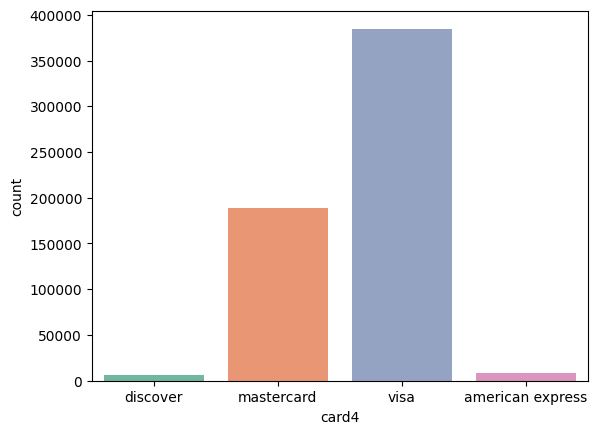

In [29]:
sns.set_palette("Set2")
sns.countplot(x=train_data["card4"])
train_data["card4"].value_counts()

card6
debit              439938
credit             148986
debit or credit        30
charge card            15
Name: count, dtype: int64

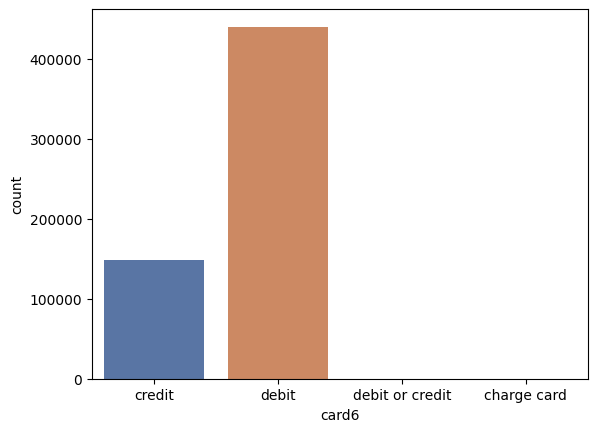

In [30]:
sns.set_palette("deep")
sns.countplot(x=train_data["card6"])
train_data["card6"].value_counts()

In [31]:
c_cols = [c for c in train_data if c[0] == 'C']
train_data[c_cols].head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


In [32]:
train_data[c_cols].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215
std,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,1.000000
75%,3.000000,3.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,12.000000,2.000000
max,4685.000000,5691.000000,26.000000,2253.000000,349.000000,2253.000000,2255.000000,3331.000000,210.000000,3257.000000,3188.000000,3188.000000,2918.000000,1429.000000


In [33]:
d_cols = ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14']
train_data[d_cols].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


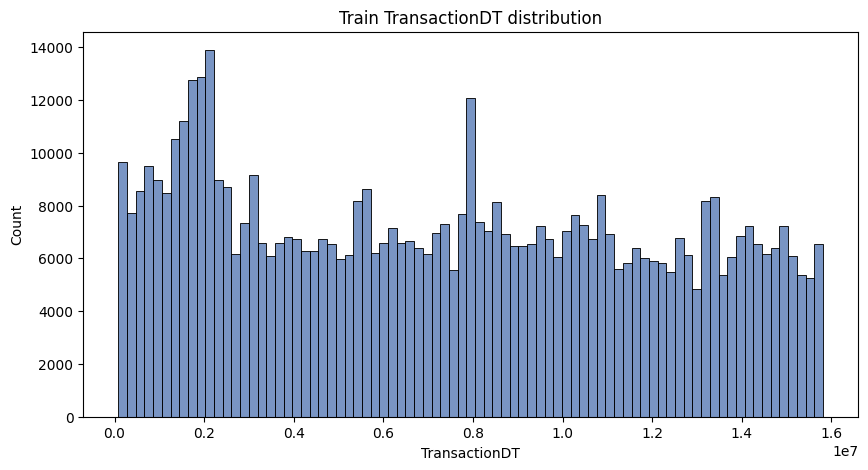

In [34]:
plt.figure(figsize=(10,5))
sns.histplot(train_data["TransactionDT"])
plt.title('Train TransactionDT distribution')
plt.show()

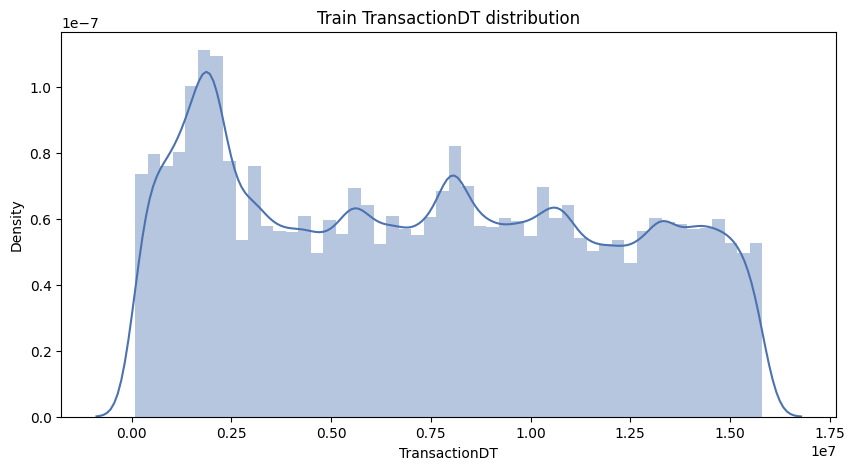

In [35]:
plt.figure(figsize=(10,5))
sns.distplot(train_data["TransactionDT"])
plt.title('Train TransactionDT distribution')
plt.show()

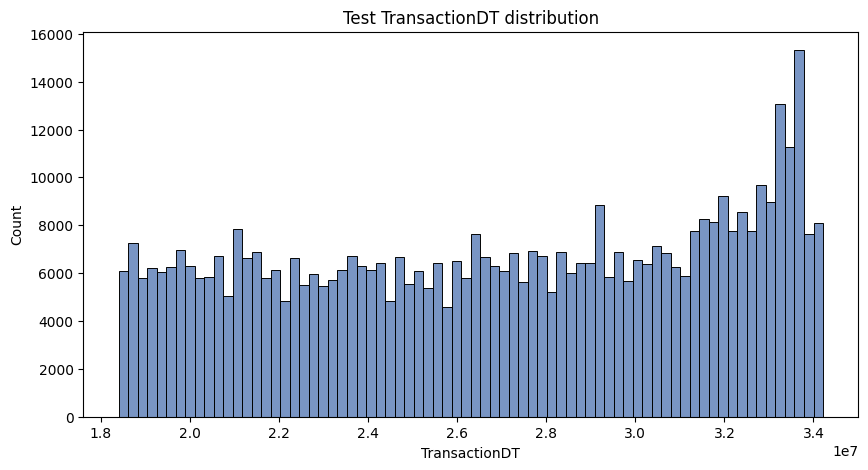

In [36]:
plt.figure(figsize=(10,5))
sns.histplot(test_data["TransactionDT"])
plt.title('Test TransactionDT distribution')
plt.show()

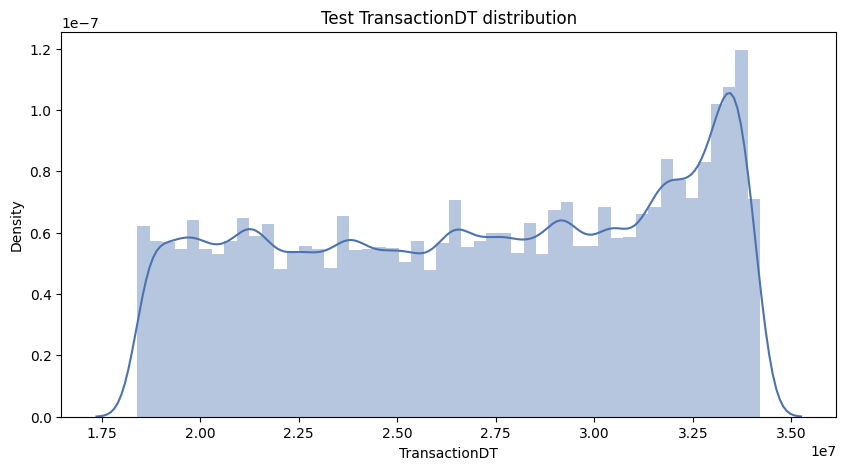

In [37]:
plt.figure(figsize=(10,5))
sns.distplot(test_data["TransactionDT"])
plt.title('Test TransactionDT distribution')
plt.show()

isFraud
0    569877
1     20663
Name: count, dtype: int64

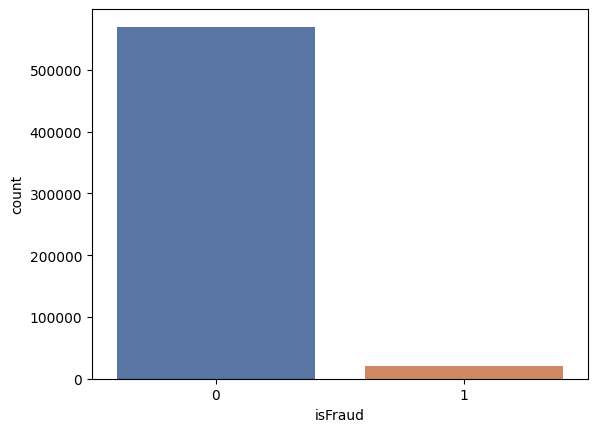

In [39]:
sns.countplot(x=train_data['isFraud'])
train_data['isFraud'].value_counts()

# Feature Engineering

In [40]:
missing_percentage = (train_data.isnull().sum().sort_values(ascending=False) / len(train_data)) * 100
print(missing_percentage)

id_24            99.196159
id_25            99.130965
id_07            99.127070
id_08            99.127070
id_21            99.126393
                   ...    
C3                0.000000
C2                0.000000
C1                0.000000
isFraud           0.000000
TransactionID     0.000000
Length: 434, dtype: float64


In [41]:
A = (np.sum(pd.isnull(train_data)).sort_values(ascending=False)/len(train_data))*100
Removed_col = A[A>0.4].index
train_data.drop(columns=Removed_col, inplace=True)

In [42]:
print(f"Shape of train data set : {train_data.shape}")

Shape of train data set : (590540, 110)


In [43]:
A = (np.sum(pd.isnull(test_data)).sort_values(ascending=False)/len(test_data))*100
Removed_col = A[A>0.4].index
test_data.drop(columns=Removed_col, inplace=True)

In [44]:
print(f"Shape of test data set : {test_data.shape}")

Shape of test data set : (506691, 93)


In [45]:
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns
# imputing with mean
train_data[numerical_columns] = train_data[numerical_columns].fillna(train_data[numerical_columns].mean())


In [46]:
print(f"Shape of train data set : {train_data.shape}")
print(f"Shape of test data set : {test_data.shape}")

Shape of train data set : (590540, 110)
Shape of test data set : (506691, 93)


In [47]:
train_columns = set(train_data.columns)
test_columns = set(test_data.columns)

columns_missing_in_test = train_columns - test_columns
print("Columns present in train set but not in test set:")
print(columns_missing_in_test)


Columns present in train set but not in test set:
{'V313', 'V300', 'C13', 'card3', 'isFraud', 'V289', 'card6', 'V301', 'V281', 'V296', 'V315', 'card4', 'V314', 'D1', 'V288', 'V283', 'V282'}


In [48]:
target = train_data['isFraud']

In [49]:
train_data.drop(columns = 'TransactionID', inplace = True)
test_data.drop(columns = 'TransactionID', inplace = True)

In [50]:
print(f"Shape of train data set : {train_data.shape}")
print(f"Shape of test data set : {test_data.shape}")

Shape of train data set : (590540, 109)
Shape of test data set : (506691, 92)


In [51]:
# Drop columns present in train set but not in test set (except 'isFraud')
columns_to_drop = [col for col in missing_column if col != 'isFraud']
train_data = train_data.drop(columns=columns_to_drop, errors='ignore')

In [52]:
print(f"Shape of train data set : {train_data.shape}")
print(f"Shape of test data set : {test_data.shape}")

Shape of train data set : (590540, 109)
Shape of test data set : (506691, 92)


In [53]:
train_columns = set(train_data.columns)
test_columns = set(test_data.columns)

columns_missing_in_test = train_columns - test_columns
print("Columns present in train set but not in test set:")
print(columns_missing_in_test)

Columns present in train set but not in test set:
{'V313', 'V300', 'C13', 'card3', 'isFraud', 'V289', 'card6', 'V301', 'V281', 'V296', 'V315', 'card4', 'V314', 'D1', 'V288', 'V283', 'V282'}


In [54]:
columns_to_drop = columns_missing_in_test - {'isFraud'}
train_data.drop(columns=columns_to_drop, inplace=True)

In [55]:
train_columns = set(train_data.columns)
test_columns = set(test_data.columns)

columns_missing_in_test = train_columns - test_columns
print("Columns present in train set but not in test set:")
print(columns_missing_in_test)

Columns present in train set but not in test set:
{'isFraud'}


In [56]:
print(f"Shape of train data set : {train_data.shape}")
print(f"Shape of test data set : {test_data.shape}")

Shape of train data set : (590540, 93)
Shape of test data set : (506691, 92)


In [57]:
target

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: int64

In [58]:
train_data.drop(columns='isFraud', inplace=True)

In [59]:
print(f"Shape of train data set : {train_data.shape}")

Shape of train data set : (590540, 92)


In [60]:
scaler = MinMaxScaler()

In [61]:
train_data = pd.get_dummies(train_data,dummy_na=True,drop_first=True)

test_data = pd.get_dummies(test_data,dummy_na=True,drop_first=True)

In [62]:
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Train Test Split

In [63]:
X_train,X_test,y_train,y_test = train_test_split(train_data,target,test_size=0.2,random_state=101)

# Modeling

# Neural Network

In [61]:
dropout=0.5

model = Sequential()
model.add(Dense(250,activation='relu',kernel_regularizer=regularizers.l1(l1=0.00001)))
model.add(Dropout(dropout))
model.add(Dense(100,activation='relu',kernel_regularizer=regularizers.l1(l1=0.00001)))
model.add(Dropout(dropout))
model.add(Dense(50,activation='relu',kernel_regularizer=regularizers.l2(l2=0.0001)))
model.add(Dropout(dropout))

model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=Adam(),loss='binary_crossentropy',metrics=['accuracy'])

In [62]:
early_stop = EarlyStopping(monitor='val_loss',patience=4,verbose=2)

In [63]:
r = model.fit(X_train, y_train,epochs = 10,validation_data=(X_test,y_test),callbacks=[early_stop])

Epoch 1/10
14764/14764 [==============================] - 50s 3ms/step - loss: 0.1531 - accuracy: 0.9647 - val_loss: 0.1389 - val_accuracy: 0.9649
Epoch 2/10
14764/14764 [==============================] - 51s 3ms/step - loss: 0.1435 - accuracy: 0.9650 - val_loss: 0.1385 - val_accuracy: 0.9649
Epoch 3/10
14764/14764 [==============================] - 55s 4ms/step - loss: 0.1426 - accuracy: 0.9650 - val_loss: 0.1386 - val_accuracy: 0.9649
Epoch 4/10
14764/14764 [==============================] - 57s 4ms/step - loss: 0.1423 - accuracy: 0.9650 - val_loss: 0.1375 - val_accuracy: 0.9649
Epoch 5/10
14764/14764 [==============================] - 53s 4ms/step - loss: 0.1425 - accuracy: 0.9650 - val_loss: 0.1379 - val_accuracy: 0.9649
Epoch 6/10
14764/14764 [==============================] - 45s 3ms/step - loss: 0.1421 - accuracy: 0.9650 - val_loss: 0.1398 - val_accuracy: 0.9649
Epoch 7/10
14764/14764 [==============================] - 48s 3ms/step - loss: 0.1420 - accuracy: 0.9650 - val_loss: 0

# Model Validation - (Neural Network)

In [64]:
model_loss = pd.DataFrame(model.history.history)
model_loss

,loss,accuracy,val_loss,val_accuracy
0,0.153143,0.964687,0.138927,0.964854
1,0.143484,0.965049,0.138538,0.964854
2,0.142636,0.965049,0.138593,0.964854
3,0.142280,0.965049,0.137545,0.964854
4,0.142525,0.965049,0.137872,0.964854
5,0.142137,0.965049,0.139820,0.964854
6,0.141998,0.965049,0.137753,0.964854
7,0.142289,0.965049,0.137611,0.964854


##  Plotting the training loss and validation loss

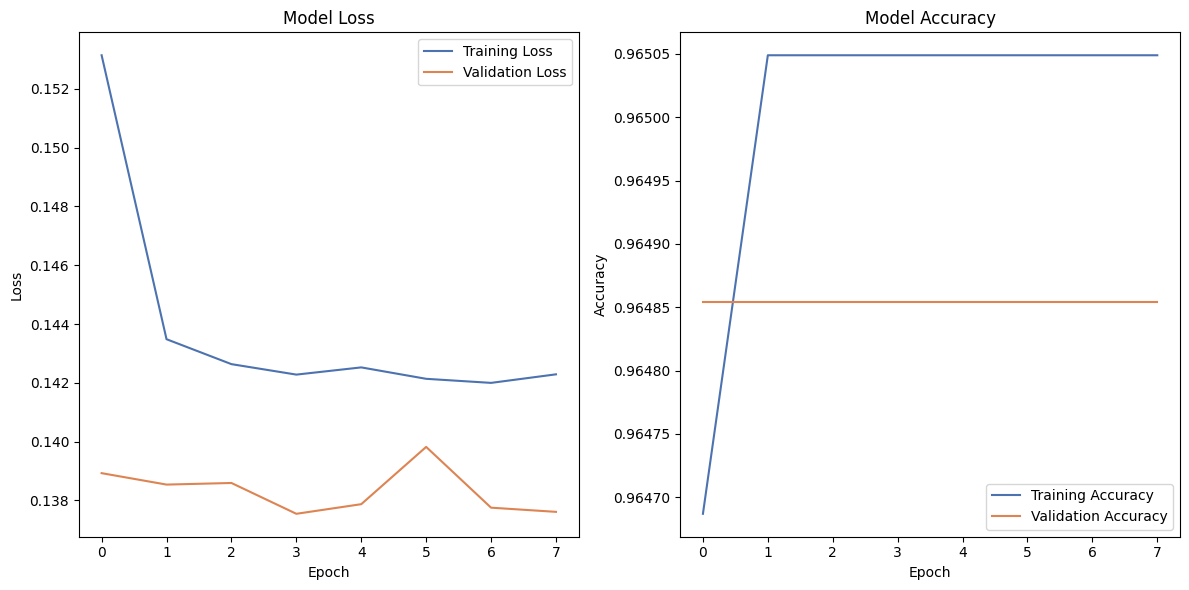

In [65]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(model_loss['loss'], label='Training Loss')
plt.plot(model_loss['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model_loss['accuracy'], label='Training Accuracy')
plt.plot(model_loss['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [66]:
loss, acc = model.evaluate(X_test,y_test, verbose=2)
print('Test Accuracy: %.5f' % acc)

3691/3691 - 5s - loss: 0.1376 - accuracy: 0.9649 - 5s/epoch - 1ms/step
Test Accuracy: 0.96485


In [67]:
pred = model.predict(X_test)
pred.shape

3691/3691 [==============================] - 5s 1ms/step


(118108, 1)

In [68]:
pred

array([[0.07867545],
       [0.01376817],
       [0.06282511],
       ...,
       [0.03469041],
       [0.06192654],
       [0.00522575]], dtype=float32)

In [69]:
predictions = model.predict(X_test)
predictions_classes = []
for i in predictions:
    prediction_class = np.argmax(i)
    predictions_classes.append(prediction_class)

cm = confusion_matrix(y_test, predictions_classes)
print(cm)

3691/3691 [==============================] - 5s 1ms/step
[[113957      0]
 [  4151      0]]


# Isolation Forest

In [71]:
iso_forest = IsolationForest(contamination=0.01, random_state=101)  

iso_forest.fit(X_train)
train_preds = iso_forest.predict(X_train)
test_preds = iso_forest.predict(X_test)

# Convert the predictions to binary labels (1 for normal, -1 for outliers)
train_preds_binary = [1 if pred == 1 else 0 for pred in train_preds]
test_preds_binary = [1 if pred == 1 else 0 for pred in test_preds]

# Evaluate the model
print("Training Set Classification Report:")
print(classification_report(y_train, train_preds_binary))

print("Testing Set Classification Report:")
print(classification_report(y_test, test_preds_binary))

print("Confusion Matrix:")
print(confusion_matrix(y_test, test_preds_binary))


Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.01      0.02    455920
           1       0.03      0.97      0.07     16512

    accuracy                           0.04    472432
   macro avg       0.46      0.49      0.04    472432
weighted avg       0.86      0.04      0.02    472432

Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.01      0.02    113957
           1       0.03      0.97      0.07      4151

    accuracy                           0.04    118108
   macro avg       0.46      0.49      0.04    118108
weighted avg       0.85      0.04      0.02    118108

Confusion Matrix:
[[  1013 112944]
 [   132   4019]]


# For the Isolation Forest model:

Precision for class 1 (fraudulent transactions) is 0.03, recall is 0.97, and F1-score is 0.07 in both the training and testing sets.

The Isolation Forest model has a better balance between precision and recall for class 1. It identifies more instances of fraudulent transactions (higher recall) while maintaining a low false positive rate (precision).

The Neural Network model has a high accuracy but seems to have a problem with predicting class 1, as it always predicts class 0.

## Plot Area under the Curve for Isolation Forest Model

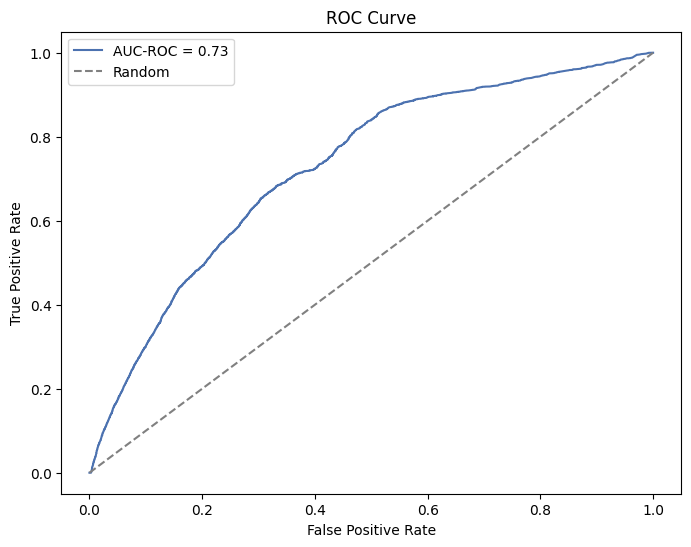

In [65]:
test_anomaly_scores = -iso_forest.decision_function(X_test)

# Create true positive rate, false positive rate, and threshold for ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_anomaly_scores)
# Area under the ROC curve
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


The classification report provides precision, recall, and F1-score for both classes (normal and anomaly).

AUROC and AUPRC are calculated using the roc_auc_score and precision_recall_curve functions, respectively.

Precision-Recall and ROC curves are plotted to visualize the trade-off between precision and recall, as well as true positive rate and false positive rate.

# Isolation Forest Hyperparameter Tuning using GridSearchCV for Anomaly Detection

In [81]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 0.9],
    'contamination': [0.01, 0.05, 0.1]
}

iso_forest = IsolationForest(random_state=101)

grid_search = GridSearchCV(iso_forest, param_grid, scoring='average_precision', cv=5)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Average Precision Score: ", grid_search.best_score_)
best_iso_forest = grid_search.best_estimator_
test_preds = best_iso_forest.predict(X_test)
test_preds_binary = [1 if pred == 1 else 0 for pred in test_preds]

print("Testing Set Classification Report:")
print(classification_report(y_test, test_preds_binary))


Best Parameters:  {'contamination': 0.01, 'max_samples': 0.5, 'n_estimators': 50}
Best Average Precision Score:  0.02340060765609205
Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.01      0.02    113957
           1       0.03      0.97      0.07      4151

    accuracy                           0.04    118108
   macro avg       0.46      0.49      0.04    118108
weighted avg       0.85      0.04      0.02    118108



Best Parameters:  {'contamination': 0.01, 'max_samples': 0.5, 'n_estimators': 50}
Best Average Precision Score:  0.02340060765609205
Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.01      0.02    113957
           1       0.03      0.97      0.07      4151

    accuracy                           0.04    118108
   macro avg       0.46      0.49      0.04    118108
weighted avg       0.85      0.04      0.02    118108

# Plot Precision-Recall curve

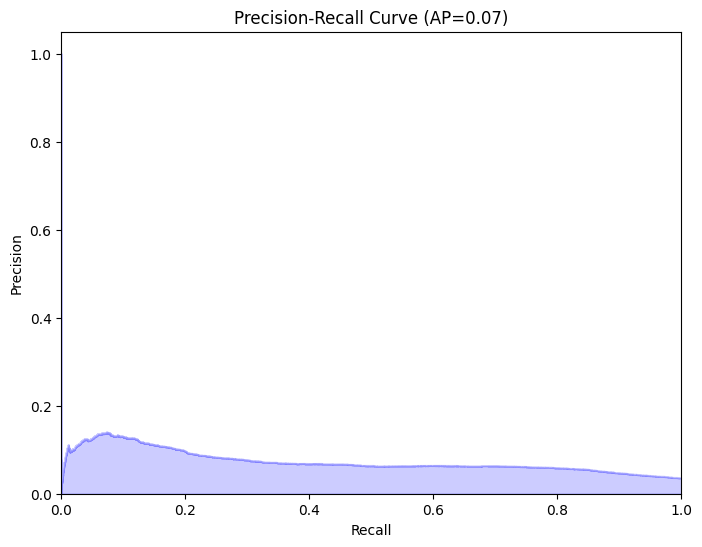

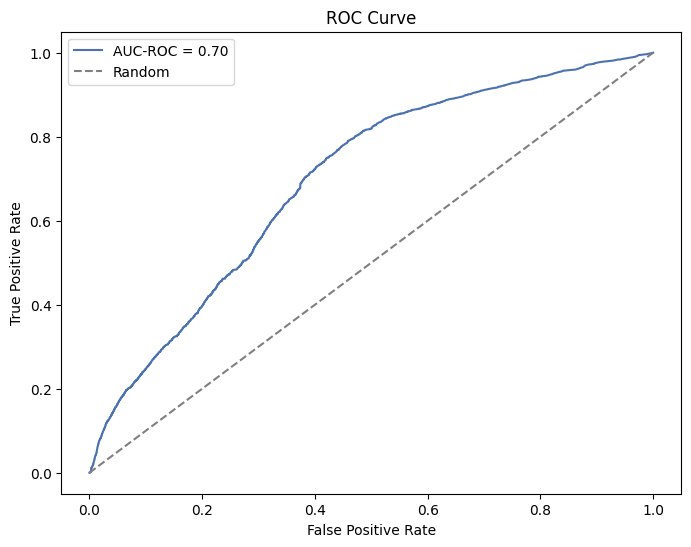

In [83]:
test_anomaly_scores = -best_iso_forest.decision_function(X_test)

precision, recall, _ = precision_recall_curve(y_test, test_anomaly_scores)
average_precision = average_precision_score(y_test, test_anomaly_scores)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AP={:.2f})'.format(average_precision))
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, test_anomaly_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# XGBoost

Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    455920
           1       0.92      0.47      0.62     16512

    accuracy                           0.98    472432
   macro avg       0.95      0.73      0.80    472432
weighted avg       0.98      0.98      0.98    472432

Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113957
           1       0.87      0.42      0.57      4151

    accuracy                           0.98    118108
   macro avg       0.92      0.71      0.78    118108
weighted avg       0.98      0.98      0.97    118108

Confusion Matrix:
[[113683    274]
 [  2391   1760]]


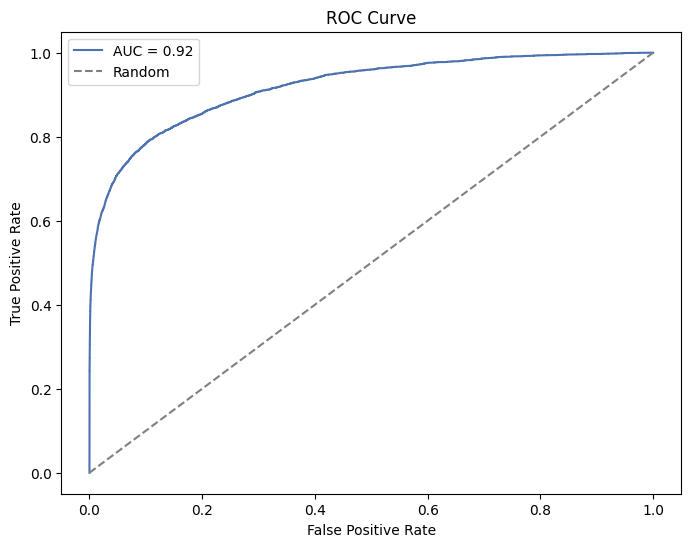

In [72]:
xgb_model = xgb.XGBClassifier(random_state=101)
xgb_model.fit(X_train, y_train)
train_preds = xgb_model.predict(X_train)
test_preds = xgb_model.predict(X_test)

print("Training Set Classification Report:")
print(classification_report(y_train, train_preds))
print("Testing Set Classification Report:")
print(classification_report(y_test, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_preds))

# Predict the probability of positive class for the training and test sets
train_preds_proba = xgb_model.predict_proba(X_train)[:, 1]
test_preds_proba = xgb_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, test_preds_proba)
roc_auc = roc_auc_score(y_test, test_preds_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# Ensemble of Isolation Forest and XGBoost

ensemble using a soft voting approach, which combines the predicted probabilities.

Combined Model:
Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    455920
           1       0.96      0.28      0.43     16512

    accuracy                           0.97    472432
   macro avg       0.97      0.64      0.71    472432
weighted avg       0.97      0.97      0.97    472432

Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    113957
           1       0.94      0.26      0.41      4151

    accuracy                           0.97    118108
   macro avg       0.95      0.63      0.70    118108
weighted avg       0.97      0.97      0.97    118108

Confusion Matrix:
[[113883     74]
 [  3065   1086]]


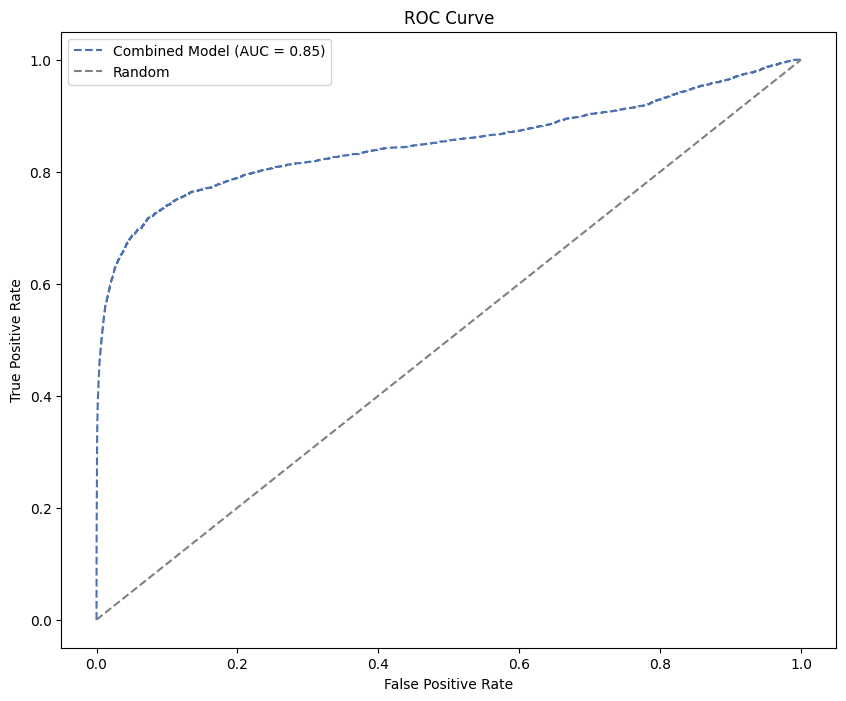

In [75]:
xgb_model.fit(X_train, y_train)
iso_forest.fit(X_train)
# Get probability scores for the training and test sets
xgb_train_probs = xgb_model.predict_proba(X_train)[:, 1]
xgb_test_probs = xgb_model.predict_proba(X_test)[:, 1]

iso_train_probs = iso_forest.decision_function(X_train)  # Use decision function for IsolationForest
iso_test_probs = iso_forest.decision_function(X_test)

# Combine probability scores
combined_train_probs = (xgb_train_probs + iso_train_probs) / 2
combined_test_probs = (xgb_test_probs + iso_test_probs) / 2

# Convert probability scores to binary predictions using a threshold
threshold = 0.5
combined_train_preds = [1 if prob > threshold else 0 for prob in combined_train_probs]
combined_test_preds = [1 if prob > threshold else 0 for prob in combined_test_probs]

# Evaluate the combined model
print("Combined Model:")
print("Training Set Classification Report:")
print(classification_report(y_train, combined_train_preds))
print("Testing Set Classification Report:")
print(classification_report(y_test, combined_test_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, combined_test_preds))

fpr_combined, tpr_combined, thresholds_combined = roc_curve(y_test, combined_test_probs)
roc_auc_combined = roc_auc_score(y_test, combined_test_probs)

plt.figure(figsize=(10, 8))
plt.plot(fpr_combined, tpr_combined, label=f'Combined Model (AUC = {roc_auc_combined:.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


**The combined model shows good overall performance, especially in terms of precision, recall, and AUC.

AUC: The AUC of 0.85 indicates good discrimination between positive and negative instances.

Accuracy: The accuracy on both the training and testing sets is high, indicating that the model is making correct predictions for the majority of instances.

Precision and Recall: The precision and recall values for class 1 (fraud) are reasonable. The model is able to identify a substantial portion of the fraud cases (recall), and when it predicts fraud, it is correct most of the time (precision). 

Confusion Matrix: The confusion matrix shows that the model is effective at correctly classifying non-fraud instances (class 0) but is less effective at classifying fraud instances (class 1). This is reflected in the recall values.

F1-Score: The F1-score, which balances precision and recall, is moderate. It's a useful metric when there is an imbalance between classes.**